In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Time series libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools

# Additional libraries
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load e-commerce data
ecommerce_data = pd.read_csv('synthetic_ecommerce_data.csv')
print(f"E-commerce data loaded: {ecommerce_data.shape[0]} rows, {ecommerce_data.shape[1]} columns")

# Load tourism data
tourism_data = pd.read_csv('world_tourism_economy_data.csv')
print(f"Tourism data loaded: {tourism_data.shape[0]} rows, {tourism_data.shape[1]} columns")

# Display basic information
print("\nE-COMMERCE DATA INFO:")
print(ecommerce_data.info())
print("\nE-COMMERCE DATA SAMPLE:")
print(ecommerce_data.head())

print("\nTOURISM DATA INFO:")
print(tourism_data.info())
print("\nTOURISM DATA SAMPLE:")
print(tourism_data.head())

E-commerce data loaded: 100000 rows, 15 columns
Tourism data loaded: 6650 rows, 11 columns

E-COMMERCE DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    100000 non-null  object 
 1   Customer_ID       100000 non-null  object 
 2   Product_ID        100000 non-null  object 
 3   Transaction_Date  100000 non-null  object 
 4   Units_Sold        100000 non-null  int64  
 5   Discount_Applied  100000 non-null  float64
 6   Revenue           100000 non-null  float64
 7   Clicks            100000 non-null  int64  
 8   Impressions       100000 non-null  int64  
 9   Conversion_Rate   100000 non-null  float64
 10  Category          100000 non-null  object 
 11  Region            100000 non-null  object 
 12  Ad_CTR            100000 non-null  float64
 13  Ad_CPC            100000 non-null  float64
 14  Ad_

In [3]:
# E-COMMERCE EDA
print("\n2.1 E-COMMERCE DATA ANALYSIS")

# Convert date column
ecommerce_data['Transaction_Date'] = pd.to_datetime(ecommerce_data['Transaction_Date'])
ecommerce_data['Year'] = ecommerce_data['Transaction_Date'].dt.year
ecommerce_data['Month'] = ecommerce_data['Transaction_Date'].dt.month
ecommerce_data['Day'] = ecommerce_data['Transaction_Date'].dt.day

# Check for missing values
print("Missing values in e-commerce data:")
print(ecommerce_data.isnull().sum())

# Check for duplicates
print(f"Duplicates in e-commerce data: {ecommerce_data.duplicated().sum()}")

# Descriptive statistics for numerical columns
print("\nDescriptive Statistics - E-commerce:")
numerical_cols_ecom = ['Units_Sold', 'Discount_Applied', 'Revenue', 'Clicks', 'Impressions',
                       'Conversion_Rate', 'Ad_CTR', 'Ad_CPC', 'Ad_Spend']
print(ecommerce_data[numerical_cols_ecom].describe())


2.1 E-COMMERCE DATA ANALYSIS
Missing values in e-commerce data:
Transaction_ID      0
Customer_ID         0
Product_ID          0
Transaction_Date    0
Units_Sold          0
Discount_Applied    0
Revenue             0
Clicks              0
Impressions         0
Conversion_Rate     0
Category            0
Region              0
Ad_CTR              0
Ad_CPC              0
Ad_Spend            0
Year                0
Month               0
Day                 0
dtype: int64
Duplicates in e-commerce data: 0

Descriptive Statistics - E-commerce:
          Units_Sold  Discount_Applied        Revenue         Clicks  \
count  100000.000000     100000.000000  100000.000000  100000.000000   
mean      128.328580          0.149871     553.110811      24.539170   
std        49.679873          0.086692     428.366294      14.412477   
min        51.000000          0.000000       7.650000       0.000000   
25%        84.000000          0.070000     221.260000      12.000000   
50%       127.000000   

In [4]:
# TOURISM EDA
print("\n2.2 TOURISM DATA ANALYSIS")

# Check for missing values
print("Missing values in tourism data:")
print(tourism_data.isnull().sum())

# Check for duplicates
print(f"Duplicates in tourism data: {tourism_data.duplicated().sum()}")

# Descriptive statistics
print("\nDescriptive Statistics - Tourism:")
numerical_cols_tourism = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports',
                         'tourism_departures', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']
print(tourism_data[numerical_cols_tourism].describe())


2.2 TOURISM DATA ANALYSIS
Missing values in tourism data:
country                    0
country_code               0
year                       0
tourism_receipts        2361
tourism_arrivals        1701
tourism_exports         2536
tourism_departures      4061
tourism_expenditures    2477
gdp                      226
inflation                982
unemployment            2992
dtype: int64
Duplicates in tourism data: 0

Descriptive Statistics - Tourism:
       tourism_receipts  tourism_arrivals  tourism_exports  \
count      4.289000e+03      4.949000e+03      4114.000000   
mean       3.062956e+10      6.263894e+07        15.506851   
std        1.291076e+11      2.049444e+08        17.758374   
min        1.000000e+05      9.000000e+02         0.000956   
25%        2.690000e+08      5.290000e+05         4.657732   
50%        1.553000e+09      2.508000e+06         8.306797   
75%        9.144227e+09      1.818000e+07        18.506710   
max        1.863069e+12      2.403074e+09       

In [5]:
print("\n" + "="*60)
print("3. DATA CLEANING AND PREPROCESSING")
print("="*60)

# E-COMMERCE DATA CLEANING
print("\n3.1 E-COMMERCE DATA CLEANING")

# Remove duplicates
ecommerce_clean = ecommerce_data.drop_duplicates()
print(f"Removed {len(ecommerce_data) - len(ecommerce_clean)} duplicate rows from e-commerce data")

# Handle outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Remove outliers from key financial metrics
original_size = len(ecommerce_clean)
for col in ['Revenue', 'Ad_Spend']:
    ecommerce_clean = remove_outliers_iqr(ecommerce_clean, col)
print(f"Removed {original_size - len(ecommerce_clean)} outlier rows from e-commerce data")

# TOURISM DATA CLEANING
print("\n3.2 TOURISM DATA CLEANING")

# Remove duplicates
tourism_clean = tourism_data.drop_duplicates()
print(f"Removed {len(tourism_data) - len(tourism_clean)} duplicate rows from tourism data")

# Handle missing values
imputer = SimpleImputer(strategy='median')
tourism_numeric_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports',
                       'tourism_departures', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']

for col in tourism_numeric_cols:
    tourism_clean[col] = imputer.fit_transform(tourism_clean[[col]]).flatten()

# Remove outliers
original_size_tourism = len(tourism_clean)
for col in ['tourism_receipts', 'gdp']:
    if tourism_clean[col].nunique() > 1:  # Only if column has variation
        tourism_clean = remove_outliers_iqr(tourism_clean, col)
print(f"Removed {original_size_tourism - len(tourism_clean)} outlier rows from tourism data")


3. DATA CLEANING AND PREPROCESSING

3.1 E-COMMERCE DATA CLEANING
Removed 0 duplicate rows from e-commerce data
Removed 2175 outlier rows from e-commerce data

3.2 TOURISM DATA CLEANING
Removed 0 duplicate rows from tourism data
Removed 2177 outlier rows from tourism data


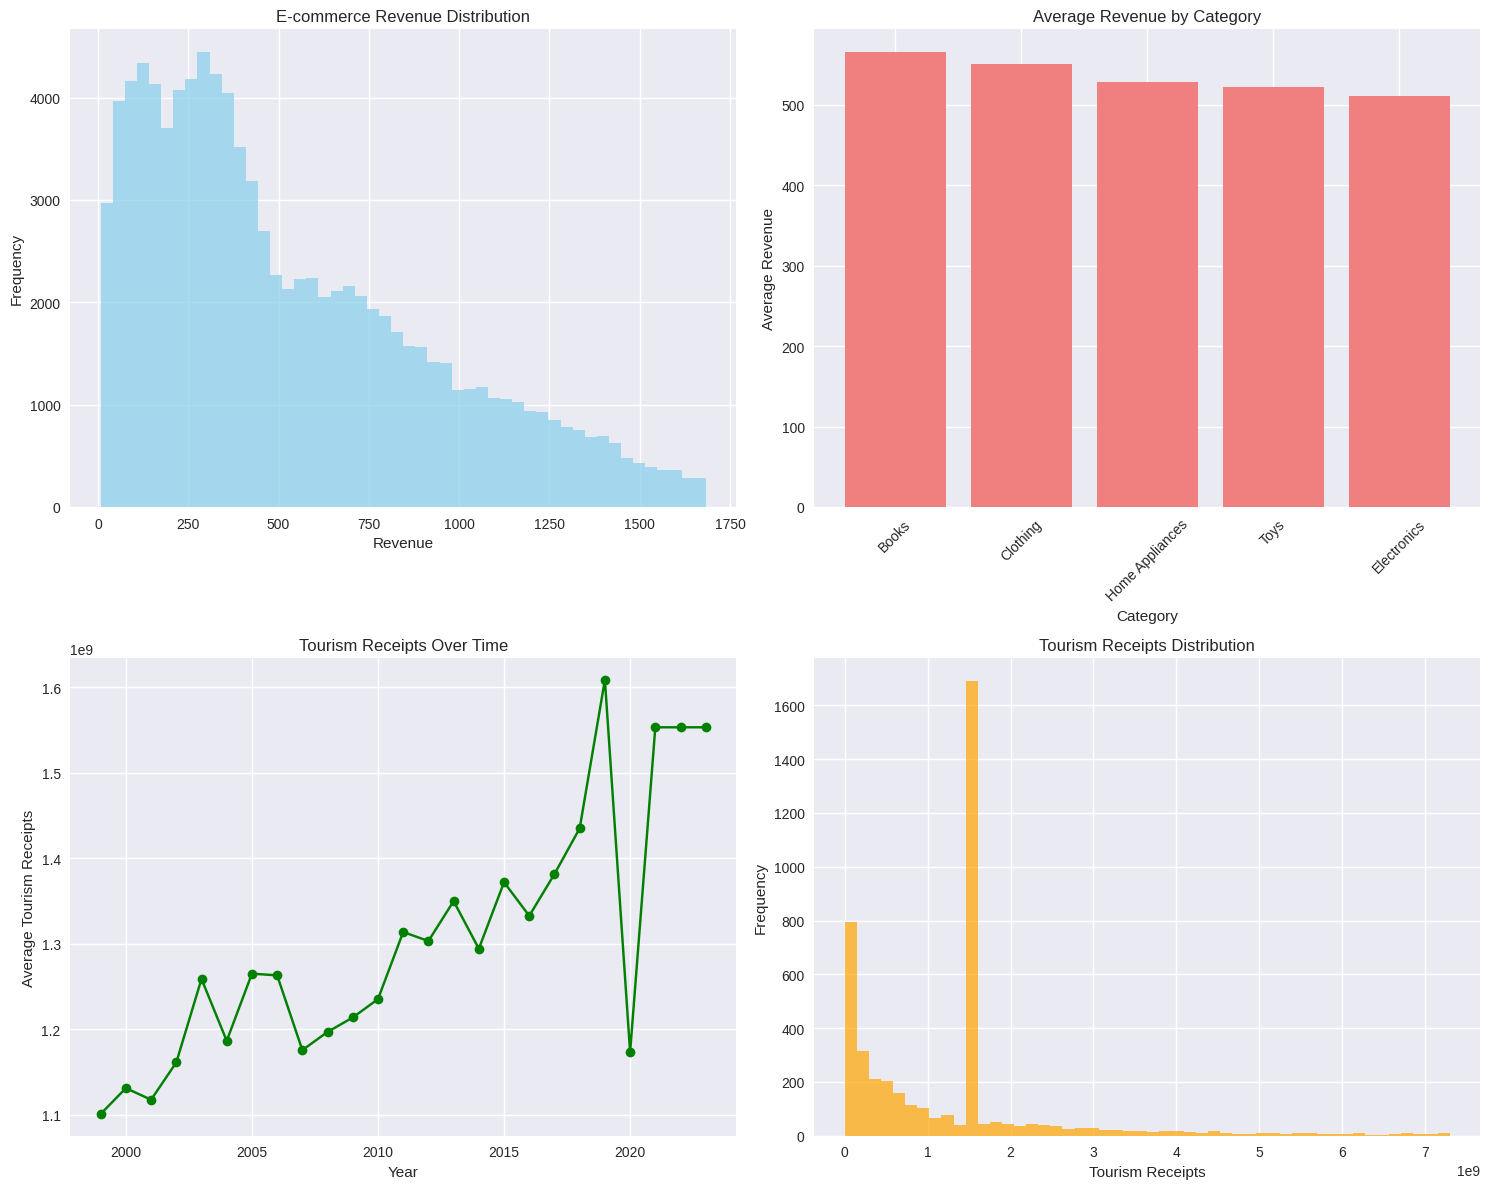


4.1 CORRELATION ANALYSIS


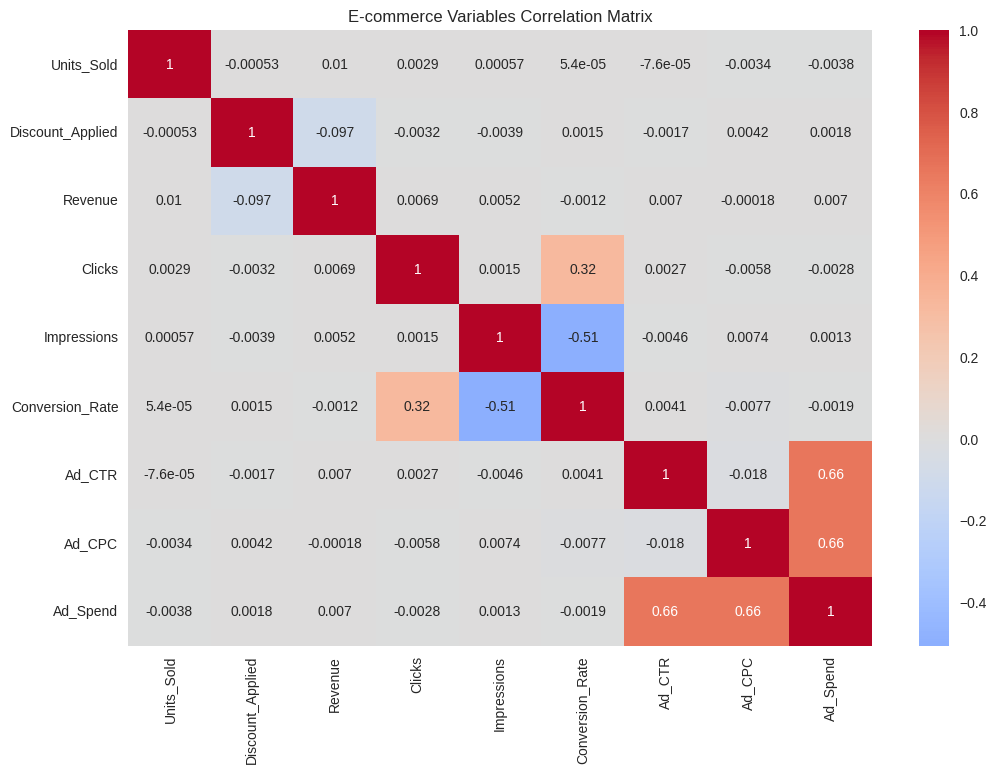

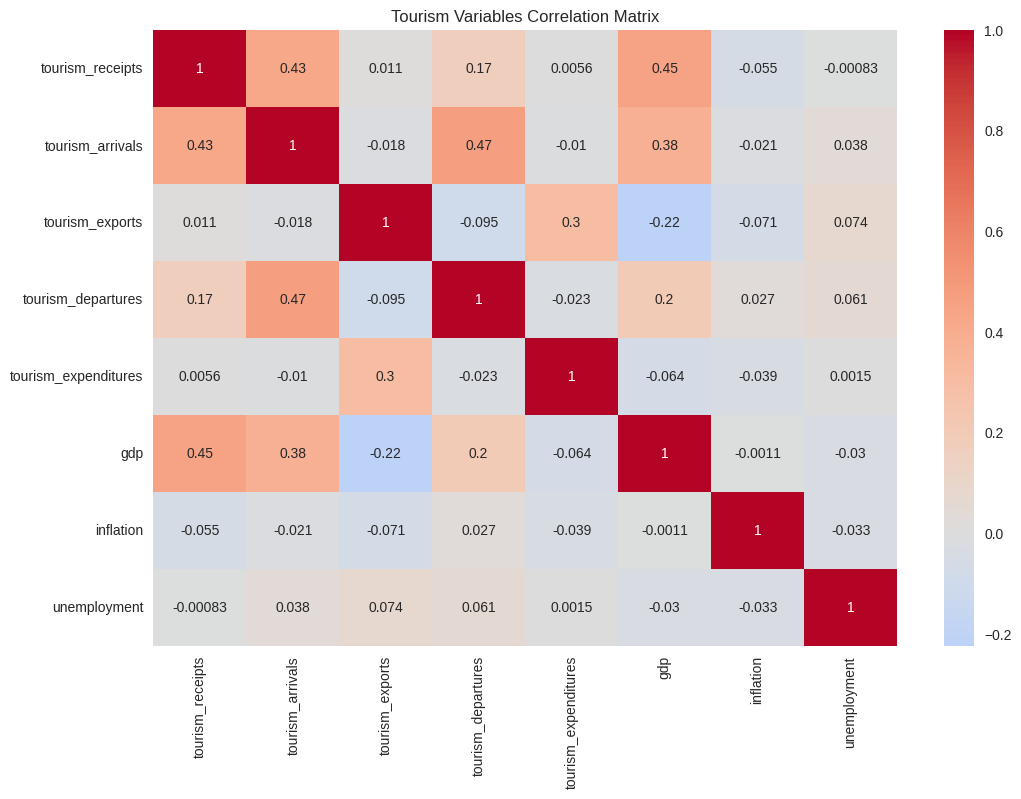

In [6]:
# Create visualizations directory structure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# E-commerce revenue distribution
axes[0,0].hist(ecommerce_clean['Revenue'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('E-commerce Revenue Distribution')
axes[0,0].set_xlabel('Revenue')
axes[0,0].set_ylabel('Frequency')

# E-commerce revenue by category
category_revenue = ecommerce_clean.groupby('Category')['Revenue'].mean().sort_values(ascending=False)
axes[0,1].bar(range(len(category_revenue)), category_revenue.values, color='lightcoral')
axes[0,1].set_title('Average Revenue by Category')
axes[0,1].set_xlabel('Category')
axes[0,1].set_ylabel('Average Revenue')
axes[0,1].set_xticks(range(len(category_revenue)))
axes[0,1].set_xticklabels(category_revenue.index, rotation=45)

# Tourism receipts over time
tourism_yearly = tourism_clean.groupby('year')['tourism_receipts'].mean()
axes[1,0].plot(tourism_yearly.index, tourism_yearly.values, marker='o', color='green')
axes[1,0].set_title('Tourism Receipts Over Time')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Average Tourism Receipts')

# Tourism receipts distribution
axes[1,1].hist(tourism_clean['tourism_receipts'], bins=50, alpha=0.7, color='orange')
axes[1,1].set_title('Tourism Receipts Distribution')
axes[1,1].set_xlabel('Tourism Receipts')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Correlation analysis
print("\n4.1 CORRELATION ANALYSIS")

# E-commerce correlations
ecom_corr = ecommerce_clean[numerical_cols_ecom].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(ecom_corr, annot=True, cmap='coolwarm', center=0)
plt.title('E-commerce Variables Correlation Matrix')
plt.show()

# Tourism correlations
tourism_corr = tourism_clean[tourism_numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(tourism_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Tourism Variables Correlation Matrix')
plt.show()

In [7]:
# E-COMMERCE TIME SERIES ANALYSIS
print("\n E-COMMERCE TIME SERIES FORECASTING")

# Aggregate daily revenue
ecom_daily = ecommerce_clean.groupby('Transaction_Date')['Revenue'].sum().reset_index()
ecom_daily = ecom_daily.sort_values('Transaction_Date')
ecom_daily.set_index('Transaction_Date', inplace=True)

# Resample to monthly data for better forecasting
ecom_monthly = ecom_daily.resample('M').sum()

print(f"E-commerce monthly data points: {len(ecom_monthly)}")

# Check stationarity
def check_stationarity(timeseries, title):
    result = adfuller(timeseries.dropna())
    print(f'\n{title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")
    return result[1] <= 0.05

is_stationary_ecom = check_stationarity(ecom_monthly['Revenue'], "E-commerce Revenue Stationarity Test")

# Make series stationary if needed
if not is_stationary_ecom:
    ecom_monthly['Revenue_diff'] = ecom_monthly['Revenue'].diff()
    check_stationarity(ecom_monthly['Revenue_diff'].dropna(), "E-commerce Revenue (Differenced)")



5.1 E-COMMERCE TIME SERIES FORECASTING
E-commerce monthly data points: 13

E-commerce Revenue Stationarity Test:
ADF Statistic: -0.977770
p-value: 0.761286
Series is non-stationary

E-commerce Revenue (Differenced):
ADF Statistic: -0.726649
p-value: 0.839725
Series is non-stationary


In [8]:
print("\n5.2 TOURISM TIME SERIES FORECASTING")

# Aggregate by year (tourism data is yearly)
tourism_yearly = tourism_clean.groupby('year')['tourism_receipts'].mean().reset_index()
tourism_yearly = tourism_yearly.sort_values('year')
tourism_yearly.set_index('year', inplace=True)

print(f"Tourism yearly data points: {len(tourism_yearly)}")

is_stationary_tourism = check_stationarity(tourism_yearly['tourism_receipts'], "Tourism Receipts Stationarity Test")



5.2 TOURISM TIME SERIES FORECASTING
Tourism yearly data points: 25

Tourism Receipts Stationarity Test:
ADF Statistic: 1.210423
p-value: 0.996057
Series is non-stationary


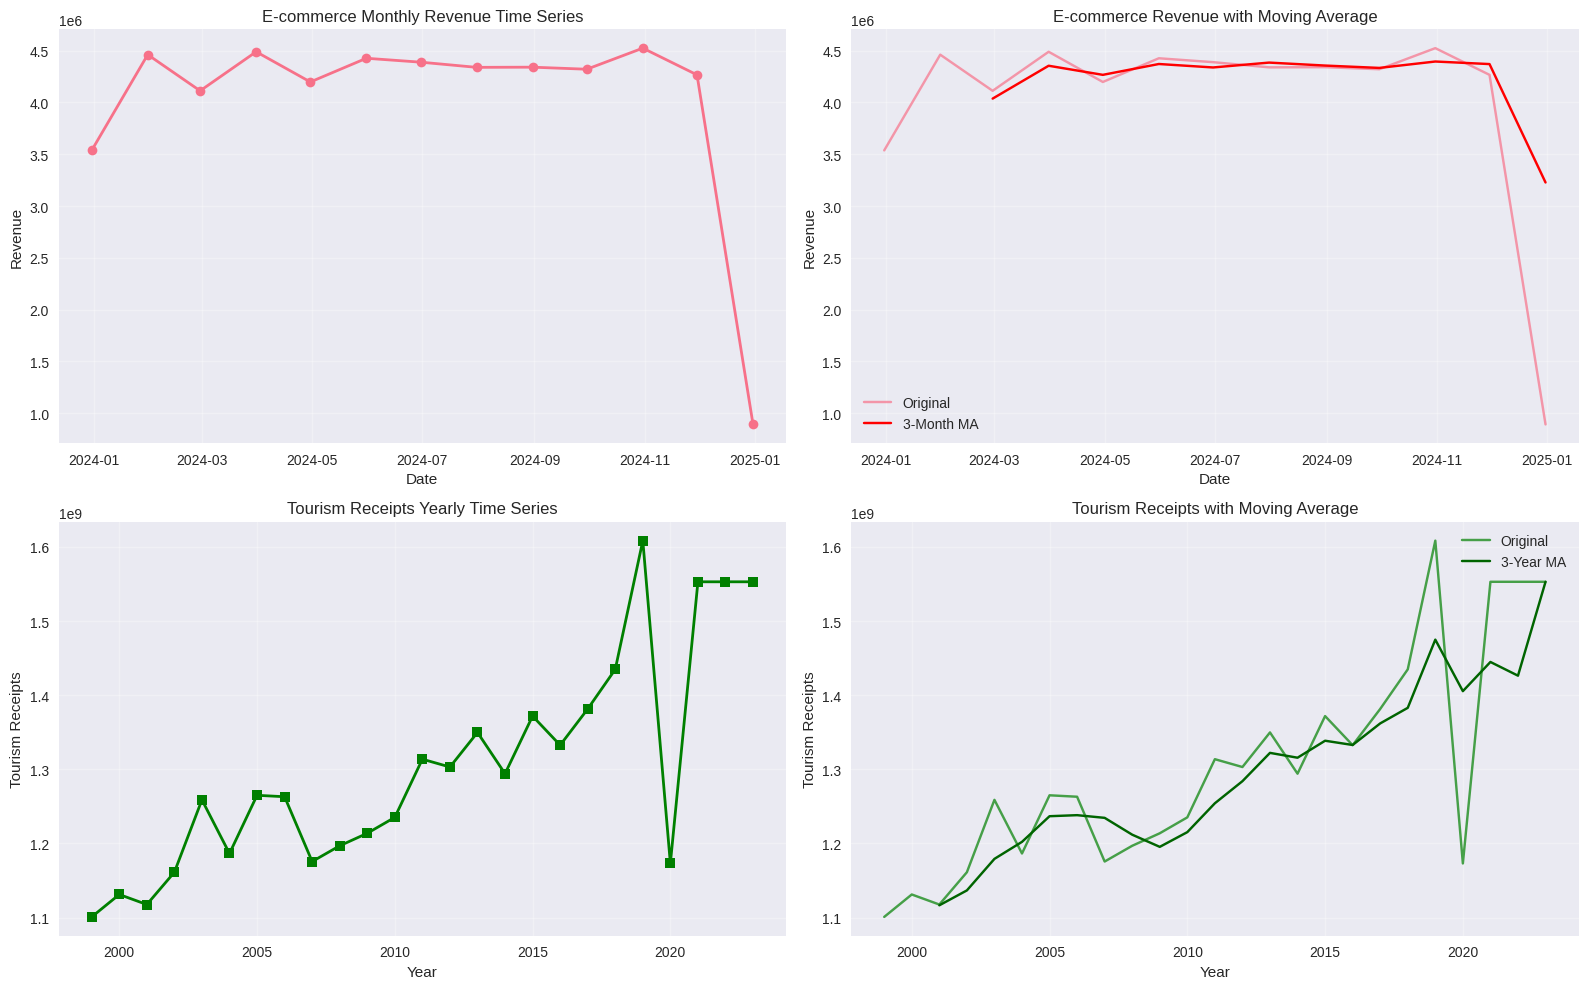

In [10]:
# Visualizations for Time Series Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# E-commerce time series plot
axes[0,0].plot(ecom_monthly.index, ecom_monthly['Revenue'], marker='o', linewidth=2)
axes[0,0].set_title('E-commerce Monthly Revenue Time Series')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Revenue')
axes[0,0].grid(True, alpha=0.3)

# E-commerce ACF plot (simple moving average as proxy)
ecom_ma = ecom_monthly['Revenue'].rolling(window=3).mean()
axes[0,1].plot(ecom_monthly.index, ecom_monthly['Revenue'], alpha=0.7, label='Original')
axes[0,1].plot(ecom_monthly.index, ecom_ma, color='red', label='3-Month MA')
axes[0,1].set_title('E-commerce Revenue with Moving Average')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Revenue')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Tourism time series plot
axes[1,0].plot(tourism_yearly.index, tourism_yearly['tourism_receipts'], marker='s', color='green', linewidth=2)
axes[1,0].set_title('Tourism Receipts Yearly Time Series')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Tourism Receipts')
axes[1,0].grid(True, alpha=0.3)

# Tourism trend analysis
tourism_ma = tourism_yearly['tourism_receipts'].rolling(window=3).mean()
axes[1,1].plot(tourism_yearly.index, tourism_yearly['tourism_receipts'], alpha=0.7, label='Original', color='green')
axes[1,1].plot(tourism_yearly.index, tourism_ma, color='darkgreen', label='3-Year MA')
axes[1,1].set_title('Tourism Receipts with Moving Average')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Tourism Receipts')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


5.3 ARIMA MODEL FITTING


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA model for e-commerce: (0, 2, 0), AIC: 339.10
E-commerce 12-month forecast generated


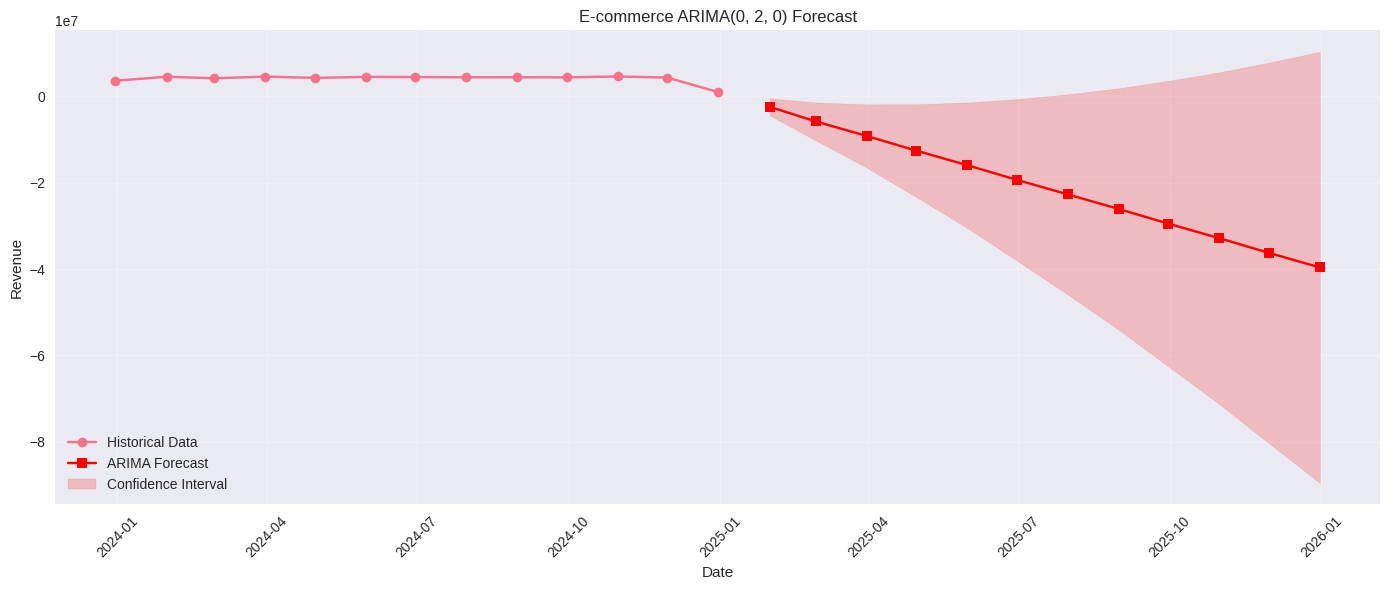

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Best ARIMA model for tourism: (0, 2, 2), AIC: 946.45
Tourism 5-year forecast generated


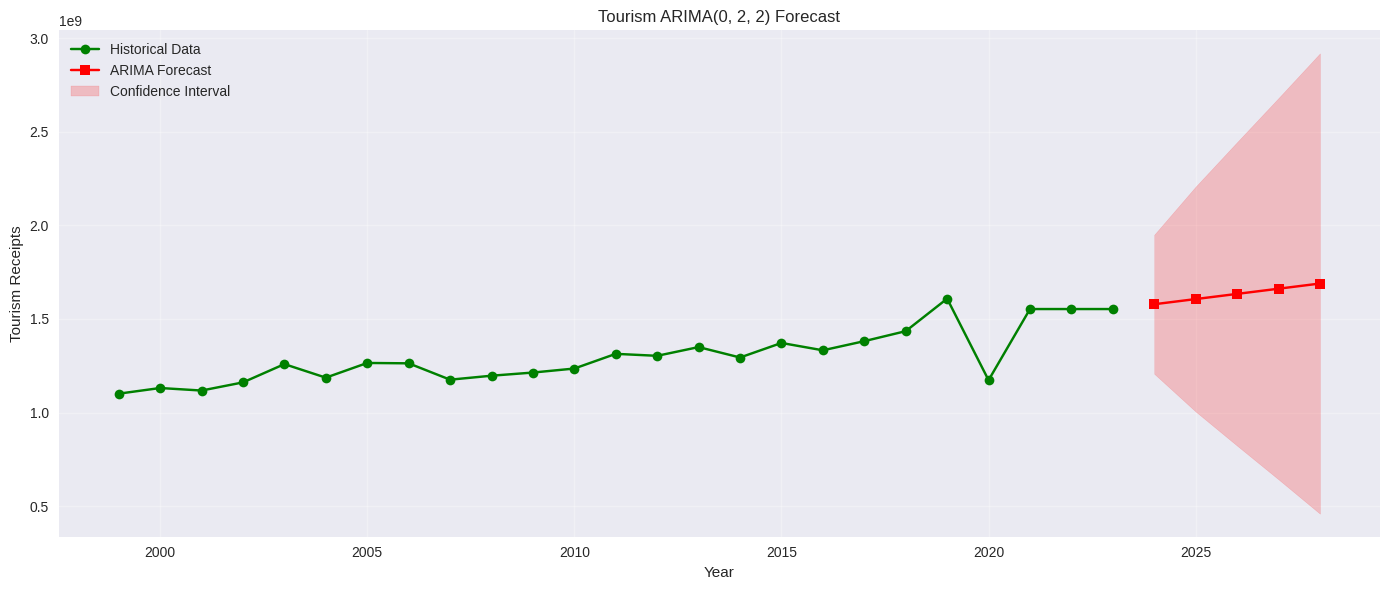

In [12]:
print("\n5.3 ARIMA MODEL FITTING")

# Function to find best ARIMA parameters
def find_best_arima(data, max_p=3, max_d=2, max_q=3):
    best_aic = np.inf
    best_params = None
    best_model = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                except:
                    continue

    return best_model, best_params, best_aic
# Fit ARIMA for e-commerce
ecom_forecast = None
ecom_arima_model = None
if len(ecom_monthly) > 12:  # Ensure we have enough data
    ecom_subset = ecom_monthly['Revenue'][-36:]  # Last 3 years
    try:
        ecom_arima_model, ecom_arima_params, ecom_arima_aic = find_best_arima(ecom_subset.dropna())
        print(f"Best ARIMA model for e-commerce: {ecom_arima_params}, AIC: {ecom_arima_aic:.2f}")

        # Forecast
        ecom_forecast = ecom_arima_model.forecast(steps=12)
        ecom_forecast_ci = ecom_arima_model.get_forecast(steps=12).conf_int()
        print("E-commerce 12-month forecast generated")

        # Plot ARIMA results for e-commerce
        plt.figure(figsize=(14, 6))

        # Historical data
        plt.plot(ecom_subset.index, ecom_subset.values, label='Historical Data', marker='o')

        # Forecast
        forecast_index = pd.date_range(start=ecom_subset.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
        plt.plot(forecast_index, ecom_forecast, label='ARIMA Forecast', color='red', marker='s')
        plt.fill_between(forecast_index, ecom_forecast_ci.iloc[:, 0], ecom_forecast_ci.iloc[:, 1],
                        color='red', alpha=0.2, label='Confidence Interval')

        plt.title(f'E-commerce ARIMA{ecom_arima_params} Forecast')
        plt.xlabel('Date')
        plt.ylabel('Revenue')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"E-commerce ARIMA fitting failed: {e}")

# Fit ARIMA for tourism
tourism_forecast = None
tourism_arima_model = None
if len(tourism_yearly) > 10:  # Ensure we have enough data
    try:
        tourism_arima_model, tourism_arima_params, tourism_arima_aic = find_best_arima(tourism_yearly['tourism_receipts'].dropna())
        print(f"Best ARIMA model for tourism: {tourism_arima_params}, AIC: {tourism_arima_aic:.2f}")

        # Forecast
        tourism_forecast = tourism_arima_model.forecast(steps=5)
        tourism_forecast_ci = tourism_arima_model.get_forecast(steps=5).conf_int()
        print("Tourism 5-year forecast generated")

        # Plot ARIMA results for tourism
        plt.figure(figsize=(14, 6))

        # Historical data
        historical_data = tourism_yearly['tourism_receipts'].dropna()
        plt.plot(historical_data.index, historical_data.values, label='Historical Data', marker='o', color='green')

        # Forecast
        last_year = historical_data.index[-1]
        forecast_years = list(range(last_year + 1, last_year + 6))
        plt.plot(forecast_years, tourism_forecast, label='ARIMA Forecast', color='red', marker='s')
        plt.fill_between(forecast_years, tourism_forecast_ci.iloc[:, 0], tourism_forecast_ci.iloc[:, 1],
                        color='red', alpha=0.2, label='Confidence Interval')

        plt.title(f'Tourism ARIMA{tourism_arima_params} Forecast')
        plt.xlabel('Year')
        plt.ylabel('Tourism Receipts')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Tourism ARIMA fitting failed: {e}")


5.4 PROPHET MODEL (ALTERNATIVE TIME SERIES METHOD)


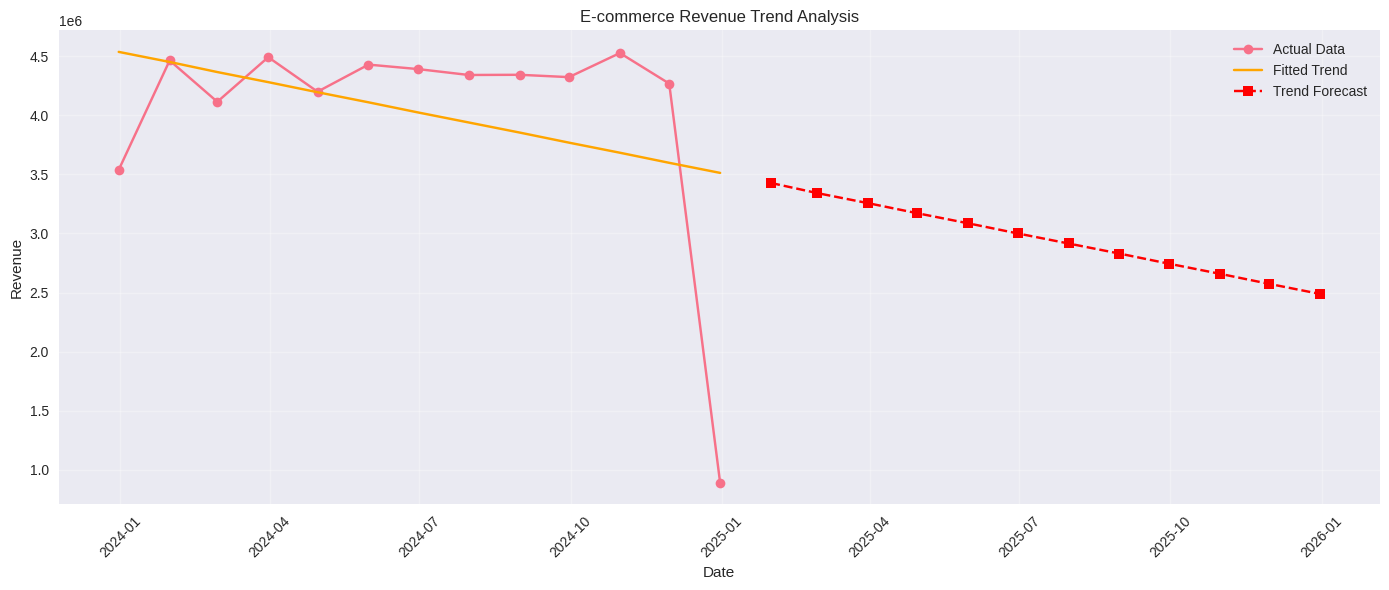

E-commerce trend slope: -85265.37 (revenue change per month)


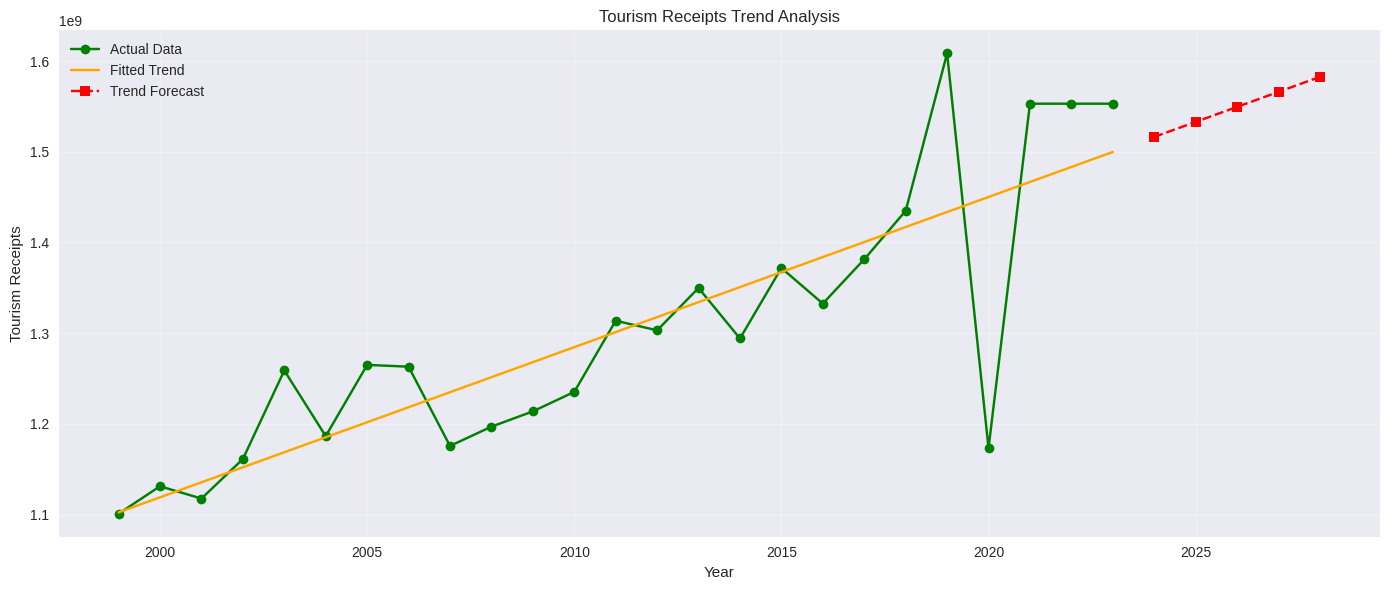

Tourism trend slope: 16555812.79 (receipts change per year)


In [13]:
print("\n5.4 PROPHET MODEL (ALTERNATIVE TIME SERIES METHOD)")

# Simple Prophet-like trend analysis for e-commerce
if len(ecom_monthly) > 12:
    # Calculate trend using linear regression
    from sklearn.linear_model import LinearRegression

    ecom_trend_data = ecom_monthly['Revenue'].dropna()
    X_trend = np.arange(len(ecom_trend_data)).reshape(-1, 1)
    y_trend = ecom_trend_data.values

    trend_model = LinearRegression()
    trend_model.fit(X_trend, y_trend)

    # Predict trend
    trend_pred = trend_model.predict(X_trend)
    future_X = np.arange(len(ecom_trend_data), len(ecom_trend_data) + 12).reshape(-1, 1)
    future_trend = trend_model.predict(future_X)

    # Plot trend analysis
    plt.figure(figsize=(14, 6))
    plt.plot(ecom_trend_data.index, y_trend, label='Actual Data', marker='o')
    plt.plot(ecom_trend_data.index, trend_pred, label='Fitted Trend', color='orange')

    # Future trend
    future_dates = pd.date_range(start=ecom_trend_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    plt.plot(future_dates, future_trend, label='Trend Forecast', color='red', linestyle='--', marker='s')

    plt.title('E-commerce Revenue Trend Analysis')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"E-commerce trend slope: {trend_model.coef_[0]:.2f} (revenue change per month)")

# Similar trend analysis for tourism
if len(tourism_yearly) > 5:
    tourism_trend_data = tourism_yearly['tourism_receipts'].dropna()
    X_trend_tourism = np.arange(len(tourism_trend_data)).reshape(-1, 1)
    y_trend_tourism = tourism_trend_data.values

    trend_model_tourism = LinearRegression()
    trend_model_tourism.fit(X_trend_tourism, y_trend_tourism)

    trend_pred_tourism = trend_model_tourism.predict(X_trend_tourism)
    future_X_tourism = np.arange(len(tourism_trend_data), len(tourism_trend_data) + 5).reshape(-1, 1)
    future_trend_tourism = trend_model_tourism.predict(future_X_tourism)

    plt.figure(figsize=(14, 6))
    plt.plot(tourism_trend_data.index, y_trend_tourism, label='Actual Data', marker='o', color='green')
    plt.plot(tourism_trend_data.index, trend_pred_tourism, label='Fitted Trend', color='orange')

    future_years = list(range(tourism_trend_data.index[-1] + 1, tourism_trend_data.index[-1] + 6))
    plt.plot(future_years, future_trend_tourism, label='Trend Forecast', color='red', linestyle='--', marker='s')

    plt.title('Tourism Receipts Trend Analysis')
    plt.xlabel('Year')
    plt.ylabel('Tourism Receipts')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Tourism trend slope: {trend_model_tourism.coef_[0]:.2f} (receipts change per year)")


In [15]:
# E-COMMERCE ML MODELS
print("\n6.1 E-COMMERCE MACHINE LEARNING MODELS")

# Prepare features for e-commerce
ecom_ml = ecommerce_clean.copy()

# Encode categorical variables
le_category = LabelEncoder()
le_region = LabelEncoder()
ecom_ml['Category_encoded'] = le_category.fit_transform(ecom_ml['Category'])
ecom_ml['Region_encoded'] = le_region.fit_transform(ecom_ml['Region'])

# Feature selection for regression
ecom_features = ['Units_Sold', 'Discount_Applied', 'Clicks', 'Impressions',
                'Conversion_Rate', 'Ad_CTR', 'Ad_CPC', 'Ad_Spend',
                'Category_encoded', 'Region_encoded', 'Month', 'Day']
ecom_target = 'Revenue'

X_ecom = ecom_ml[ecom_features]
y_ecom = ecom_ml[ecom_target]

# Split data
X_ecom_train, X_ecom_test, y_ecom_train, y_ecom_test = train_test_split(
    X_ecom, y_ecom, test_size=0.2, random_state=42)

# Scale features
scaler_ecom = StandardScaler()
X_ecom_train_scaled = scaler_ecom.fit_transform(X_ecom_train)
X_ecom_test_scaled = scaler_ecom.transform(X_ecom_test)

# Initialize models
ecom_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=50)
}

# Train and evaluate e-commerce models
ecom_results = {}
print("\nE-commerce Regression Results:")

for name, model in ecom_models.items():
    if name == 'Neural Network':
        model.fit(X_ecom_train_scaled, y_ecom_train)
        y_pred = model.predict(X_ecom_test_scaled)
    else:
        model.fit(X_ecom_train, y_ecom_train)
        y_pred = model.predict(X_ecom_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_ecom_test, y_pred))
    mae = mean_absolute_error(y_ecom_test, y_pred)
    mape = np.mean(np.abs((y_ecom_test - y_pred) / y_ecom_test)) * 10

    ecom_results[name] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")

# Classification task: High/Low Revenue
print("\n6.2 E-COMMERCE CLASSIFICATION (High/Low Revenue)")

# Create binary target
revenue_median = ecom_ml['Revenue'].median()
ecom_ml['Revenue_Class'] = (ecom_ml['Revenue'] > revenue_median).astype(int)

y_ecom_class = ecom_ml['Revenue_Class']
X_ecom_train_cl, X_ecom_test_cl, y_ecom_train_cl, y_ecom_test_cl = train_test_split(
    X_ecom, y_ecom_class, test_size=0.2, random_state=42)

# Classification models
ecom_classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=50)
}

print("\nE-commerce Classification Results:")
for name, classifier in ecom_classifiers.items():
    if name == 'Neural Network':
        classifier.fit(X_ecom_train_scaled, y_ecom_train_cl)
        y_pred_cl = classifier.predict(X_ecom_test_scaled)
    else:
        classifier.fit(X_ecom_train_cl, y_ecom_train_cl)
        y_pred_cl = classifier.predict(X_ecom_test_cl)

    accuracy = accuracy_score(y_ecom_test_cl, y_pred_cl)
    print(f"{name} Accuracy: {accuracy:.4f}")


6.1 E-COMMERCE MACHINE LEARNING MODELS

E-commerce Regression Results:
Random Forest: RMSE=398.73, MAE=330.98, MAPE=18.99%
Gradient Boosting: RMSE=393.31, MAE=324.95, MAPE=18.33%
Neural Network: RMSE=395.41, MAE=326.99, MAPE=18.43%

6.2 E-COMMERCE CLASSIFICATION (High/Low Revenue)

E-commerce Classification Results:
Random Forest Accuracy: 0.5221
Gradient Boosting Accuracy: 0.5366
Neural Network Accuracy: 0.5107


In [16]:
print("\n6.3 TOURISM MACHINE LEARNING MODELS")

# Prepare features for tourism
tourism_ml = tourism_clean.copy()

# Encode country
le_country = LabelEncoder()
tourism_ml['country_encoded'] = le_country.fit_transform(tourism_ml['country'])

# Feature selection for regression
tourism_features = ['year', 'tourism_arrivals', 'tourism_exports', 'tourism_departures',
                   'tourism_expenditures', 'gdp', 'inflation', 'unemployment', 'country_encoded']
tourism_target = 'tourism_receipts'

# Remove rows with missing target
tourism_ml_clean = tourism_ml.dropna(subset=[tourism_target])

X_tourism = tourism_ml_clean[tourism_features]
y_tourism = tourism_ml_clean[tourism_target]

# Split data
X_tourism_train, X_tourism_test, y_tourism_train, y_tourism_test = train_test_split(
    X_tourism, y_tourism, test_size=0.2, random_state=42)

# Scale features
scaler_tourism = StandardScaler()
X_tourism_train_scaled = scaler_tourism.fit_transform(X_tourism_train)
X_tourism_test_scaled = scaler_tourism.transform(X_tourism_test)

# Initialize models
tourism_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=50)
}

# Train and evaluate tourism models
tourism_results = {}
print("\nTourism Regression Results:")

for name, model in tourism_models.items():
    if name == 'Neural Network':
        model.fit(X_tourism_train_scaled, y_tourism_train)
        y_pred = model.predict(X_tourism_test_scaled)
    else:
        model.fit(X_tourism_train, y_tourism_train)
        y_pred = model.predict(X_tourism_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_tourism_test, y_pred))
    mae = mean_absolute_error(y_tourism_test, y_pred)
    mape = np.mean(np.abs((y_tourism_test - y_pred) / y_tourism_test)) * 10

    tourism_results[name] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")

# Classification task: High/Low Tourism Receipts
print("\n6.4 TOURISM CLASSIFICATION (High/Low Receipts)")

tourism_receipts_median = tourism_ml_clean['tourism_receipts'].median()
tourism_ml_clean['Receipts_Class'] = (tourism_ml_clean['tourism_receipts'] > tourism_receipts_median).astype(int)

y_tourism_class = tourism_ml_clean['Receipts_Class']
X_tourism_train_cl, X_tourism_test_cl, y_tourism_train_cl, y_tourism_test_cl = train_test_split(
    X_tourism, y_tourism_class, test_size=0.2, random_state=42)

# Classification models
tourism_classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=50)
}

print("\nTourism Classification Results:")
for name, classifier in tourism_classifiers.items():
    if name == 'Neural Network':
        classifier.fit(X_tourism_train_scaled, y_tourism_train_cl)
        y_pred_cl = classifier.predict(X_tourism_test_scaled)
    else:
        classifier.fit(X_tourism_train_cl, y_tourism_train_cl)
        y_pred_cl = classifier.predict(X_tourism_test_cl)

    accuracy = accuracy_score(y_tourism_test_cl, y_pred_cl)
    print(f"{name} Accuracy: {accuracy:.4f}")


6.3 TOURISM MACHINE LEARNING MODELS

Tourism Regression Results:
Random Forest: RMSE=429339677.53, MAE=195510009.38, MAPE=10.87%
Gradient Boosting: RMSE=581590988.62, MAE=376770970.67, MAPE=42.50%
Neural Network: RMSE=1866030358.94, MAE=1339673720.04, MAPE=10.00%

6.4 TOURISM CLASSIFICATION (High/Low Receipts)

Tourism Classification Results:
Random Forest Accuracy: 0.9810
Gradient Boosting Accuracy: 0.9698
Neural Network Accuracy: 0.9698



7.1 REGRESSION MODEL COMPARISON

E-commerce Models Performance:
                         RMSE         MAE       MAPE
Random Forest      398.726135  330.977865  18.992804
Gradient Boosting  393.307673  324.948095  18.326129
Neural Network     395.405767  326.993791  18.432902

Tourism Models Performance:
                           RMSE           MAE       MAPE
Random Forest      4.293397e+08  1.955100e+08  10.872805
Gradient Boosting  5.815910e+08  3.767710e+08  42.495522
Neural Network     1.866030e+09  1.339674e+09   9.997625


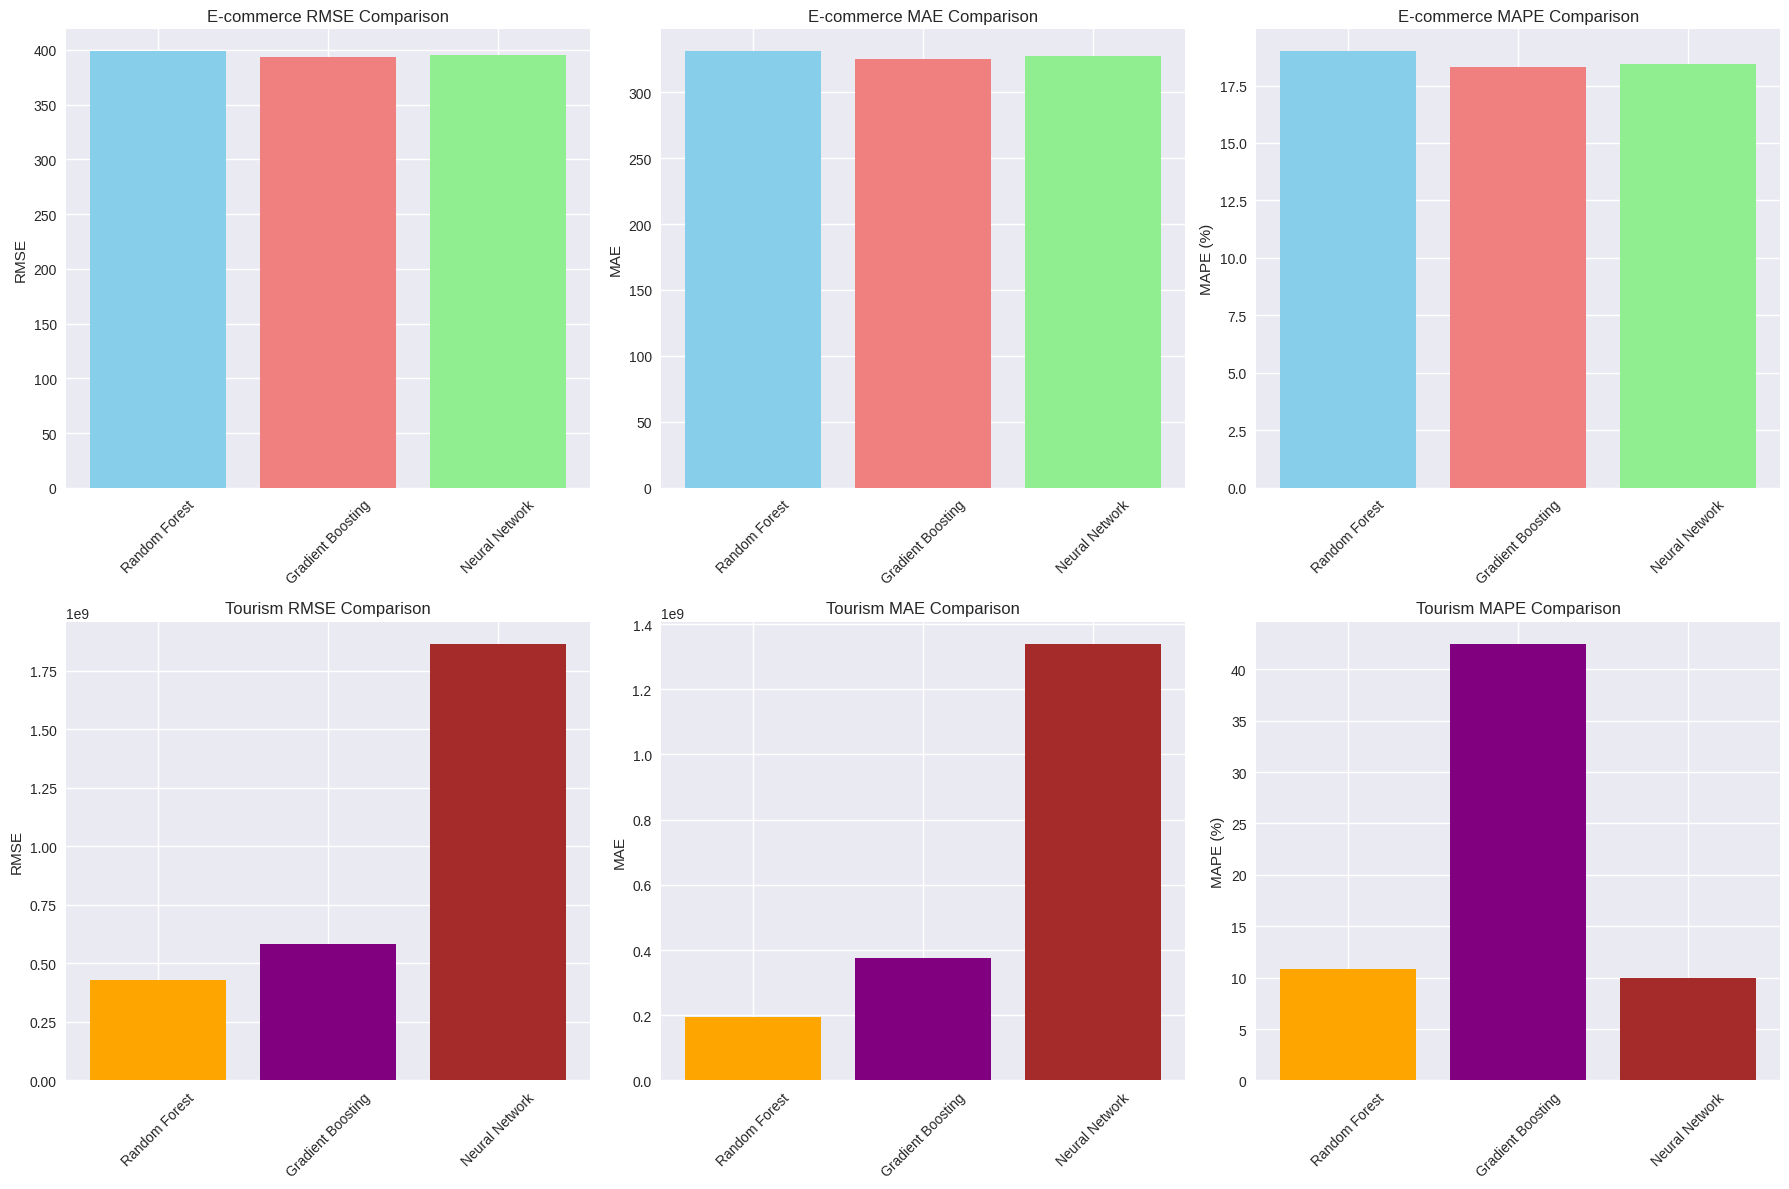

In [17]:
# Create comparison dataframes
ecom_comparison = pd.DataFrame(ecom_results).T
tourism_comparison = pd.DataFrame(tourism_results).T

print("\n7.1 REGRESSION MODEL COMPARISON")
print("\nE-commerce Models Performance:")
print(ecom_comparison)

print("\nTourism Models Performance:")
print(tourism_comparison)

# Visualization of model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# E-commerce RMSE
axes[0,0].bar(ecom_comparison.index, ecom_comparison['RMSE'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('E-commerce RMSE Comparison')
axes[0,0].set_ylabel('RMSE')
axes[0,0].tick_params(axis='x', rotation=45)

# E-commerce MAE
axes[0,1].bar(ecom_comparison.index, ecom_comparison['MAE'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,1].set_title('E-commerce MAE Comparison')
axes[0,1].set_ylabel('MAE')
axes[0,1].tick_params(axis='x', rotation=45)

# E-commerce MAPE
axes[0,2].bar(ecom_comparison.index, ecom_comparison['MAPE'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,2].set_title('E-commerce MAPE Comparison')
axes[0,2].set_ylabel('MAPE (%)')
axes[0,2].tick_params(axis='x', rotation=45)

# Tourism RMSE
axes[1,0].bar(tourism_comparison.index, tourism_comparison['RMSE'], color=['orange', 'purple', 'brown'])
axes[1,0].set_title('Tourism RMSE Comparison')
axes[1,0].set_ylabel('RMSE')
axes[1,0].tick_params(axis='x', rotation=45)

# Tourism MAE
axes[1,1].bar(tourism_comparison.index, tourism_comparison['MAE'], color=['orange', 'purple', 'brown'])
axes[1,1].set_title('Tourism MAE Comparison')
axes[1,1].set_ylabel('MAE')
axes[1,1].tick_params(axis='x', rotation=45)

# Tourism MAPE
axes[1,2].bar(tourism_comparison.index, tourism_comparison['MAPE'], color=['orange', 'purple', 'brown'])
axes[1,2].set_title('Tourism MAPE Comparison')
axes[1,2].set_ylabel('MAPE (%)')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


8.1 E-COMMERCE FEATURE IMPORTANCE:
             feature  importance
0         Units_Sold    0.120922
3        Impressions    0.118910
5             Ad_CTR    0.118498
7           Ad_Spend    0.113537
6             Ad_CPC    0.102038
11               Day    0.092511
2             Clicks    0.086835
10             Month    0.067268
4    Conversion_Rate    0.066841
1   Discount_Applied    0.066083
9     Region_encoded    0.023886
8   Category_encoded    0.022671

8.2 TOURISM FEATURE IMPORTANCE:
                feature  importance
1      tourism_arrivals    0.376458
2       tourism_exports    0.261698
5                   gdp    0.147288
4  tourism_expenditures    0.061941
8       country_encoded    0.049433
6             inflation    0.031701
3    tourism_departures    0.029761
0                  year    0.023561
7          unemployment    0.018159


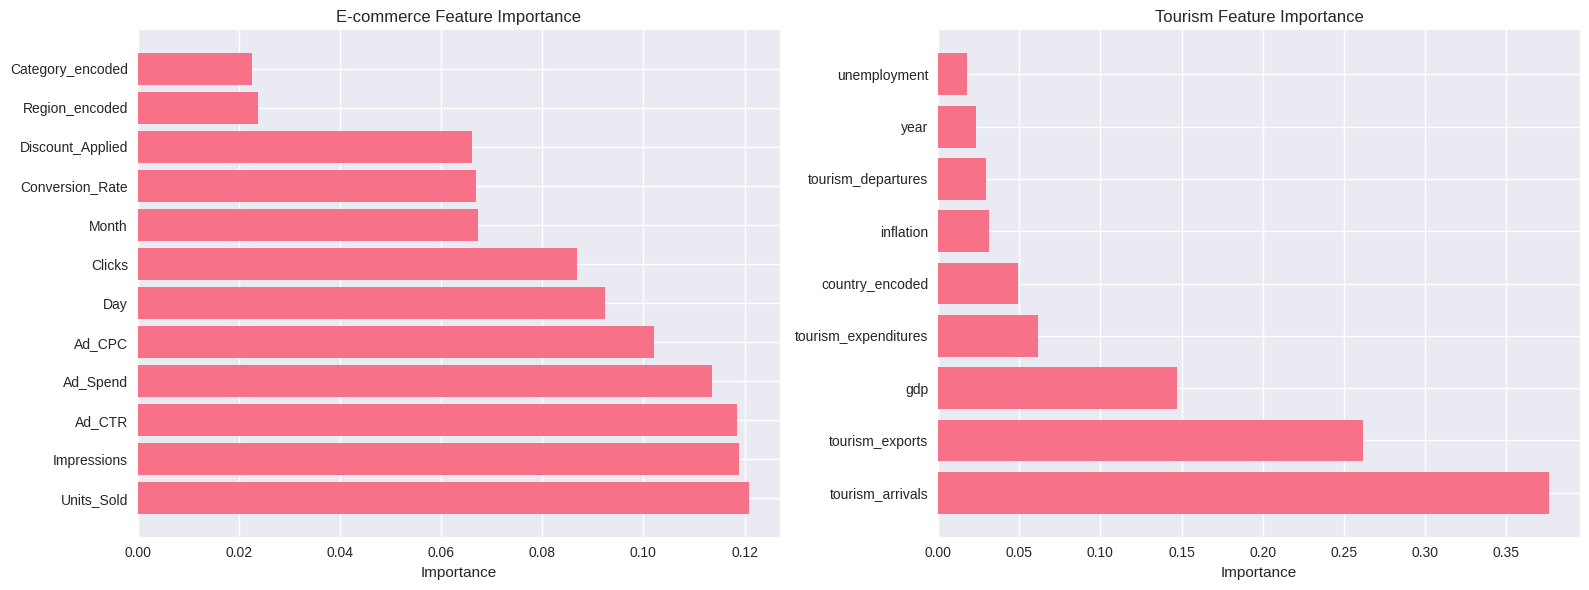

In [18]:
# E-commerce feature importance (using Random Forest)
rf_ecom = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ecom.fit(X_ecom_train, y_ecom_train)

ecom_feature_importance = pd.DataFrame({
    'feature': ecom_features,
    'importance': rf_ecom.feature_importances_
}).sort_values('importance', ascending=False)

print("\n8.1 E-COMMERCE FEATURE IMPORTANCE:")
print(ecom_feature_importance)

# Tourism feature importance (using Random Forest)
rf_tourism = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tourism.fit(X_tourism_train, y_tourism_train)

tourism_feature_importance = pd.DataFrame({
    'feature': tourism_features,
    'importance': rf_tourism.feature_importances_
}).sort_values('importance', ascending=False)

print("\n8.2 TOURISM FEATURE IMPORTANCE:")
print(tourism_feature_importance)

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# E-commerce
axes[0].barh(ecom_feature_importance['feature'], ecom_feature_importance['importance'])
axes[0].set_title('E-commerce Feature Importance')
axes[0].set_xlabel('Importance')

# Tourism
axes[1].barh(tourism_feature_importance['feature'], tourism_feature_importance['importance'])
axes[1].set_title('Tourism Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [19]:
print("\n9.1 KEY FINDINGS:")

# Find best performing models
best_ecom_model = ecom_comparison.loc[ecom_comparison['RMSE'].idxmin()]
best_tourism_model = tourism_comparison.loc[tourism_comparison['RMSE'].idxmin()]

print(f"\nBest E-commerce Model: {best_ecom_model.name}")
print(f"- RMSE: {best_ecom_model['RMSE']:.2f}")
print(f"- MAE: {best_ecom_model['MAE']:.2f}")
print(f"- MAPE: {best_ecom_model['MAPE']:.2f}%")

print(f"\nBest Tourism Model: {best_tourism_model.name}")
print(f"- RMSE: {best_tourism_model['RMSE']:.2f}")
print(f"- MAE: {best_tourism_model['MAE']:.2f}")
print(f"- MAPE: {best_tourism_model['MAPE']:.2f}%")

print("\n9.2 SECTOR-WISE ANALYSIS:")

# E-commerce insights
print("\nE-COMMERCE INSIGHTS:")
print("- Top performing categories:", ecommerce_clean.groupby('Category')['Revenue'].mean().nlargest(3).index.tolist())
print("- Most profitable regions:", ecommerce_clean.groupby('Region')['Revenue'].mean().nlargest(3).index.tolist())
print("- Average conversion rate:", f"{ecommerce_clean['Conversion_Rate'].mean():.3f}")
print("- Revenue correlation with Ad Spend:", f"{ecommerce_clean['Revenue'].corr(ecommerce_clean['Ad_Spend']):.3f}")

# Tourism insights
top_tourism_countries = tourism_clean.groupby('country')['tourism_receipts'].mean().nlargest(5)
print("\nTOURISM INSIGHTS:")
print("- Top 5 countries by average receipts:", top_tourism_countries.index.tolist())
print("- Tourism receipts trend:", "Increasing" if tourism_yearly['tourism_receipts'].iloc[-1] > tourism_yearly['tourism_receipts'].iloc[0] else "Decreasing")
print("- GDP correlation with tourism receipts:", f"{tourism_clean['tourism_receipts'].corr(tourism_clean['gdp']):.3f}")

print("\n9.3 MODEL EFFECTIVENESS COMPARISON:")

# Compare average MAPE across sectors
ecom_avg_mape = ecom_comparison['MAPE'].mean()
tourism_avg_mape = tourism_comparison['MAPE'].mean()

print(f"Average MAPE across all models:")
print(f"- E-commerce: {ecom_avg_mape:.2f}%")
print(f"- Tourism: {tourism_avg_mape:.2f}%")

if ecom_avg_mape < tourism_avg_mape:
    print("- E-commerce models show better predictive accuracy")
else:
    print("- Tourism models show better predictive accuracy")


9.1 KEY FINDINGS:

Best E-commerce Model: Gradient Boosting
- RMSE: 393.31
- MAE: 324.95
- MAPE: 18.33%

Best Tourism Model: Random Forest
- RMSE: 429339677.53
- MAE: 195510009.38
- MAPE: 10.87%

9.2 SECTOR-WISE ANALYSIS:

E-COMMERCE INSIGHTS:
- Top performing categories: ['Books', 'Clothing', 'Home Appliances']
- Most profitable regions: ['Asia', 'North America', 'Europe']
- Average conversion rate: 0.198
- Revenue correlation with Ad Spend: 0.007

TOURISM INSIGHTS:
- Top 5 countries by average receipts: ['Portugal', 'Malaysia', 'Poland', 'Sweden', 'Egypt, Arab Rep.']
- Tourism receipts trend: Increasing
- GDP correlation with tourism receipts: 0.454

9.3 MODEL EFFECTIVENESS COMPARISON:
Average MAPE across all models:
- E-commerce: 18.58%
- Tourism: 21.12%
- E-commerce models show better predictive accuracy
